In [2]:
# In this notebook we explain and compare the performance of the frequency localized and time localized inference algorithms, providing with formulas
# the experiments/error_comparison.py script
import numpy as np
from signals import  generate_frequency_localized_samples, generate_time_localized_samples
from sampling import  power_law_samples_symmetric
from fourier import compute_fourier_coeff, compute_inverse_fourier_coeff, get_fourier_coeffs
from kernels import  periodic_sobolev
from regularization import compute_lambda
from fourier_inference import  compute_prediction, compute_error
from plotting import  plot_compare_approximations

import matplotlib.pyplot as plt

In [3]:
seed = 42  # or any integer of choice
rng = np.random.default_rng(seed)

#### A priori assumptions and space/frequency localization.

- $ G = \mathbb{R}/\mathbb{Z} = [0,1] $
- $  \widehat{K} \simeq \frac{1}{|\ell|^2} $ so that $ \mathcal{H} = H^1 $ 
- $  w_* \in H^2 $  so that 
  $$
  \sum_{\xi \in \mathbb{Z}} \left| (\mathcal{F} w_*)_\ell \right|^2 \ell^4 < +\infty
  $$
- $\sigma_\ell = \widehat{K}_\ell\, \mathbb{E}[ \left| (\mathcal{F} X)_\ell \right|^2 ] $
  
so that the source conditions can be written as
$$
\sum_{\ell\in\mathbb{Z}} \frac{\left| (\mathcal{F} w_*)_\ell \right|^2 \ell^2}{\sigma_\ell^{2r}} < +\infty.
$$



In [4]:
# Number of input functions
num_samples = 100

grid_size = 2**12 # grid points

t_left = 0
t_right = 1   # time interval

time_span = t_right - t_left

time_array = np.linspace(t_left,t_right,grid_size)
noise = .07 # noise level in the data


## Target function

W construct the target function fixing its Fourier coefficients decay rate 
$$
\hat{w}^\ast \sim \frac{1}{l^\beta},
$$ 
with decay rate $\beta$.
Since

$$
  \sum_{\ell \in \mathbb{Z}} \left| (\mathcal{F} w_*)_\ell \right|^2 \ell^4 < +\infty = C \sum_{\ell \in \mathbb{Z}} \frac{1}{|\ell|^{2\beta}} \ell^4 
=  C \sum_{\ell \in \mathbb{Z}} \frac{1}{\ell^{2\beta-4}}   < +\infty,
  $$

we choose $2\beta-4 > 1$ so $\beta > 2.5$.

Note: we can use a `balancing_vector` to lift the high frequencies.

$$
\hat{w}^\ast \sim \frac{c \ A_\ell}{l^\beta},
$$ 

If $A_\ell = |\ell|^\alpha$ then

$$
  \sum_{\ell \in \mathbb{Z}} \left| (\mathcal{F} w_*)_\ell \right|^2 \ell^4 < +\infty = C \sum_{\ell \in \mathbb{Z}} \frac{|\ell|^{2\alpha}}{|\ell|^{2\beta}} \ell^4 
=  C \sum_{\ell \in \mathbb{Z}} \frac{1}{\ell^{2\beta-2\alpha -4}}   < +\infty,
  $$

$\beta-\alpha>2.5$


(Alternatively, construct in time space with `construct_even_fourier_signal` or `construct_sine_series_signal`)


In [5]:
# Ground truth function (target) and observation  noise         

# y_i = x_i * target + noise, where x_i is the input signal

#parameter for target signal
# target_decay = 2.51  # decay rate of the target signal  ~ 1/target_decay

# target_coeff= get_fourier_coeffs(target_decay, time_span, grid_size, c0=1, scale=1)
# target = np.fft.ifft(target_coeff*grid_size).real


from fourier import get_fourier_coeffs_balanced
freqs = np.fft.fftfreq(grid_size, time_span / grid_size)

balancing_vector = np.ones(grid_size)
balancing_vector[freqs != 0] = np.random.normal(2,.5, grid_size)[freqs != 0]*np.abs(freqs[freqs != 0]) ** 1 # or any desired exponent
target_coeff = get_fourier_coeffs_balanced(decay=2.51, time_span=time_span, n_sample_points=grid_size, c0=.5, scale=.7, balancing_vector=balancing_vector)
target = np.fft.ifft(target_coeff*grid_size).real



##Alternative target signal, constructed in the time domain
# from signals import construct_sine_series_signal
# target = construct_sine_series_signal(time_array, target_decay, 50)
# target_coeff = compute_fourier_coeff(target, time_span)

Text(0.5, 1.0, 'Balancing vector $A_\\ell$')

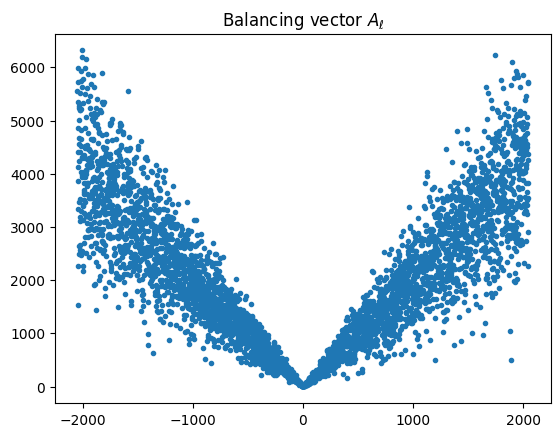

In [6]:
# balancing_vector[:20]
plt.plot(freqs, balancing_vector,'.')
plt.title('Balancing vector $A_\ell$')

/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


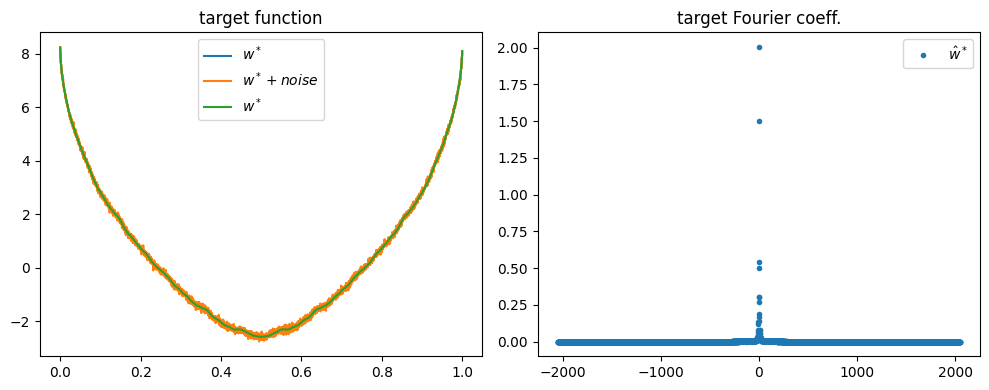

In [7]:
#Visualise target signal
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(10, 4))
ax1.plot(time_array, compute_inverse_fourier_coeff(target_coeff,time_span), label=r'$w^*$')
ax1.plot(time_array, target + noise*rng.standard_normal(grid_size), label=r'$w^* + noise$')
ax1.plot(time_array, target, label=r'$w^*$')
#plot target with noise
ax1.set_title('target function')
ax1.legend()


# Get the frequency bins. These tell us which Fourier mode (l) corresponds to each index.
ax2.plot(freqs,target_coeff, '.', label='$\hat{w}^*$')
ax2.set_title('target Fourier coeff.')
ax2.legend()
plt.tight_layout()

## Kernel
### Periodic Sobolev  kernel  

with $\hat{K} \simeq 1/{|l|}^2$, so that $\mathcal{H}   = H^1$
$$
K(t)=3t^2-3t+1 \quad t\in [0,1] , 
$$
with Fourier coefficients:

$$
\hat{K}_\ell= 
	\begin{cases}
	\frac{3}{2\pi^2}  \frac{1}{\ell^2} & \ell\neq 0 \\
         \frac{1}{2}     & \ell=0
	\end{cases}
$$

We construct the Sobolev kernel starting from the Fourier coefficients $\hat{K}_\ell$ (and the inverse Fourier transform to visualise in time space).

In [8]:
# we construct the kernel coefficients with decay rate 2

kernel_decay =  2 # decay rate of the  complex exponential kernel   #1.01
kernel_coeff = get_fourier_coeffs(kernel_decay, time_span, grid_size, c0=1/2, scale=3/(2*np.pi**2))


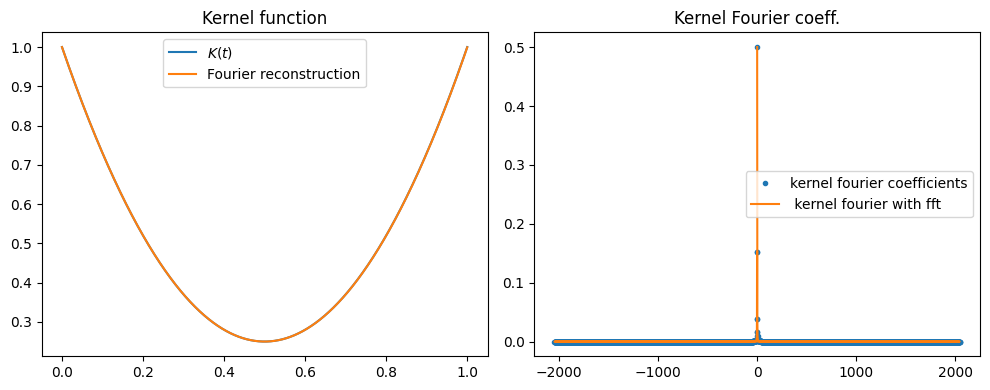

In [9]:
# visualize the kernel's fourier coefficients decay  (for the complex exponential kernel)

fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(10, 4))
ax1.plot(time_array, periodic_sobolev(time_array), label=r'$K(t)$')
ax1.set_title('Kernel function')
ax1.plot(time_array, np.fft.ifft(kernel_coeff*grid_size), label='Fourier reconstruction')
ax1.legend()


# Get the frequency bins. These tell us which Fourier mode (l) corresponds to each index.
freqs = np.fft.fftfreq(grid_size, time_span / grid_size)
ax2.plot(freqs,kernel_coeff, '.', label='kernel fourier coefficients')
ax2.plot(freqs,(compute_fourier_coeff(periodic_sobolev(time_array),time_span)), label=' kernel fourier with fft')   #shouldn't they be real??
ax2.set_title('Kernel Fourier coeff.')
ax2.legend()
plt.tight_layout()

## 1. Frequency-Localized Inputs

Random frequencies are drawn from a (symmetric) power-law distribution and then each sample is generated as a complex exponential evaluated at the points in the `time_array`.  
$$
\text{Summary:} \quad \boxed{X(t) = \left[ e^{2\pi i \ell_1 t}, \, e^{2\pi i \ell_2 t}, \, \dots, \, e^{2\pi i \ell_{n_{\text{samples}}} t} \right] \quad \text{with} 
\quad \ell_k \sim \text{PowerLaw}(\alpha, f_{\max}).}
$$

**Random frequency generation:** 
   Each _frequency_ $\ell_k$ is sampled according to a power-law distribution $p_\ell \propto |\ell|^{-\alpha} \quad \text{for } 0 < \ell \leq f_{\max}, \ \text{and} \ - f_{\max}< \ell < 0$. 
   $$
   \ell_1, \ell_2, \dots, \ell_{n_{\text{samples}}} \sim p_l =\text{PowerLaw}(\alpha, f_{\max}).
   $$
   where $\alpha$ is the exponent (provided as the `exponent` parameter) and $f_{\max}$ corresponds to `max_value`.

**Signal Generation:** For each frequency $\ell_k$ and for every time point $t$ in the `time_array`, the sample is computed as:
   $$
   X_k(t) = e^{2\pi i \ell_k t}.
   $$
   Thus, the entire sample matrix $X$ (with dimensions corresponding to the number of time points by the number of samples) is given by:
   $
   X(t) = \begin{bmatrix}
   e^{2\pi i \ell_1 t} & e^{2\pi i \ell_2 t} & \cdots & e^{2\pi i \ell_{n_{\text{nsamples}}} t}
   \end{bmatrix}.
   $


### Source conditions
With these $X_k$, then 
$$ 
\sigma_\ell \simeq |\ell|^{-2} p_\ell  \to
|\ell|^{-3} \quad p_\ell \to \ell^{-1} . \quad \quad \text{So} \quad b=3, r=\frac{1}{3}.
$$

- Decay rate parameter for freq-loc inputs: $\alpha = 1$
- Maximum frequency for power law samples: $f_{max} = M$
- Regularization parameter: $b = 3$




In [10]:
# freq-loc input signals 
freq_loc_inputs_decay = 1 
freq_max = grid_size // 2

r_freq_loc = 1 / 3
b_freq_loc = 3

X_freq_loc = generate_frequency_localized_samples(num_samples, time_array, freq_max, freq_loc_inputs_decay, power_law_samples_symmetric, seed=seed)
const_lam = 1e-4

In [11]:
# run inference for freq-localized signals
lamb_freq_loc = compute_lambda(const_lam, num_samples, r_freq_loc, b_freq_loc)

prediction_four_coeff_freq_loc, prediction_freq_loc = compute_prediction(
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_coeff=target_coeff,
    noise=noise,
    lamb=lamb_freq_loc,
    X = X_freq_loc,
)

Note: we compute the approximation $w_n^\lambda$ via its Fourier coefficients:
$$
 (\mathcal{F}{w}_n^\lambda)_\xi=
    \frac{\frac{\hat{K}_\xi}{n}\sum_{i=1}^n (\mathcal{F} Y_i)_\xi \overline{(\mathcal{F}
        X_i)_\xi} }{\frac{\hat{K}_\xi}{n}\sum_{i=1}^n |(\mathcal{F} X_i)_\xi|^2+ \lambda_n
      } \quad  \xi\in \hat{G}_* 
$$

## 2. Space-Localized Inputs
Random localization centers are drawn from a distribution on  $G=[0,1]$, and then each sample is generated as a time-localized indicator function (or "window") around the chosen center.  

We consider the signals 
$$      
 X(t) =
 \begin{cases}
   \frac{1}{2\delta} &   \tau-\delta\leq  t \leq \tau+\delta \\
     0 & \text{otherwise}
 \end{cases}
$$

with $\tau$ a random variable taking values in $G=[0,1]$ and $\delta \in \mathbb{R}^+$ is small.

We generate these signals via `generate_time_localized_samples`. 

First, we genrate $n_\text{samples}$ random variables
     $$
     \tau_1, \tau_2, \dots, \tau_{n_{\text{samples}}} \sim \mathcal{N}(\mu, \sigma^2). \quad \mu =0.5,\  \sigma = 0.16
     $$
  
Second, we then generate the signals 
$$
X_k(t) = \frac{1}{2\delta} \cdot \mathbf{1}_{\{|t-\tau_k | \le \delta\}},
$$
where $\mathbf{1}_{\{|t-\tau| \le \delta\}}$ is the indicator function that is $1$ if $|t-\tau | \le \delta$ and $0$ otherwise.

### Source conditions
With these $X_k$, then 
$$ 
\sigma_\ell \simeq \hat{K}_\ell \ \text{sinc}^2(2\pi \delta \ell) \simeq |\ell|^{-2}
    \text{sinc}^2(2\pi\delta\ell)\  \operatornamewithlimits{\longrightarrow}_{\delta\to 0} \ |\ell|^{-2} . \quad \text{So} \quad b=2, \ r=\frac{1}{2}.
$$

- Localization parameter $\delta$ for space-loc inputs: $\delta = .001$
- Regularization parameter: $b = 2$


In [12]:
#time-loc input signals 
loc_parameter = 0.001
r_time_loc = 1 / 2
b_time_loc = 2

X_time_loc = generate_time_localized_samples(num_samples, time_array, loc_parameter,seed=seed+1)


In [13]:
# run inference for time-localized signals
lamb_time_loc = compute_lambda(const_lam, num_samples, r_time_loc, b_time_loc)

prediction_four_coeff_time_loc, prediction_time_loc = compute_prediction(
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_coeff=target_coeff,
    noise=noise,
    lamb=lamb_time_loc,
    X= X_time_loc
)

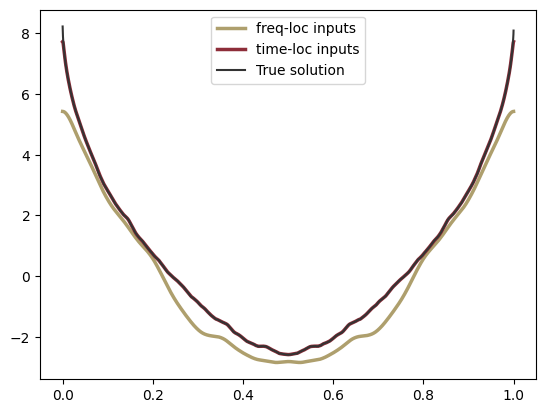

In [14]:
plot_compare_approximations(time_array = time_array, target=target, prediction_freq_loc=prediction_freq_loc, prediction_time_loc=prediction_time_loc)

## Error computation

### Approxmation error $||w_n^\lambda-w_*||^2_\mathcal{H}$

In the error comparison between the settings of the two types of inputs, we analyze the $\mathcal{H}$-error decay as a function of the sample size $n$, by computing the quantity: 

$$
||w_n^\lambda-w_*||^2_\mathcal{H} 
$$

where, as explained above, $w_n^\lambda$ is computed via its Fourier coefficients formula., and the norm in $\mathcal{H}$ is given by 

$
 ||w||^2_\mathcal{H} = \sum_{\xi\in \hat{G}}  \dfrac{(\mathcal{F} w)_{\xi}
  \overline{(\mathcal{F} w)_{\xi} }}{\hat{K}_{\xi} } = \sum_{\xi\in \hat{G}}  \dfrac{|(\mathcal{F} w)_{\xi}|^2
   }{\hat{K}_{\xi} } . $

We can compute the error for the two types of inputs and compare the decay rate:
$$
||w_n^\lambda-w_*||^2_\mathcal{H} \lesssim 
 n^{-\frac{2r}{2r+1+b^{-1}}},
$$




### Operator error $||\Sigma^{\frac{1}{2}}(w_n^\lambda-w_*)||^2_\mathcal{H}$

To compute this we will need the eigenvalues $\sigma_\ell = \hat{K}_\ell\, \mathbb{E}[ \left| (\mathcal{F} X)_\ell \right|^2 ]$ of the covariance operator $\Sigma$.

The squared norm becomes 
$$
||\Sigma^{\frac{1}{2}}(w_n^\lambda-w_*)||^2_\mathcal{H}  = \sum_{\xi\in \hat{G}}  \dfrac{\sigma_\xi|(\mathcal{F} w^\lambda_n)_{\xi}-(\mathcal{F} w^\star)_{\xi}|^2
   }{\hat{K}_{\xi} } \lesssim 
 n^{-\frac{2r+1}{2r+1+b^{-1}}} .
$$

In [15]:
num_experiments = 5  # number of experiments to run for each sample size

In [16]:
# # error computation for frequency localised signals

sample_gen_params_freq_loc = {
    "max_value": freq_max,
    "exponent": freq_loc_inputs_decay,
    "power_law_func": power_law_samples_symmetric,
    "seed": rng,   ## to get error bars you need rng.. not seed!
}

# error_squared_sampmean_freq_loc, error_squared_sampstd_freq_loc = compute_error(
#     num_samples,
#     num_experiments,
#     time_array,
#     time_span,
#     kernel_coeff,
#     target_coeff,
#     noise,
#     r_freq_loc,
#     b_freq_loc,
#     const_lam,
#     generate_frequency_localized_samples,
#     sample_gen_params_freq_loc,
# )




In [17]:
# Compute lambda_left and lambda_right based on the squared magnitudes.
lambda_left = np.min(np.abs(compute_fourier_coeff(X_freq_loc, time_span))**2)
lambda_right = np.max(np.abs(compute_fourier_coeff(X_freq_loc, time_span))**2)

# Choose a small positive value to ensure a strictly positive lower bound.
epsilon = 1e-10

# Adjust the lower bound: subtract the offset only if it doesn't push the value below epsilon.
offset = 1e-1
if lambda_left > offset:
    lower_bound = lambda_left - offset
else:
    lower_bound = lambda_left  # or set to a fixed small value, e.g., epsilon

# Also ensure that lower_bound is positive.
lower_bound = max(lower_bound, epsilon)

# Adjust the upper bound if needed.
upper_bound = lambda_right + 1

# Now generate lambda candidates in logarithmic space.
num_candidates = 50  # for example
lambda_candidates = np.logspace(np.log10(lower_bound), np.log10(upper_bound), num=num_candidates)

print("Lower bound for lambda:", lower_bound)
print("Upper bound for lambda:", upper_bound)


# with lambda optimization
from fourier_inference import compute_error_grid_search_over_lambda

error_mean, error_std = compute_error_grid_search_over_lambda(
    num_samples=150,
    num_experiments=9,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_coeff=target_coeff,
    noise=noise,
    sample_generator=generate_frequency_localized_samples,  
    sample_gen_params=sample_gen_params_freq_loc,           
    lambda_candidates=lambda_candidates
)

Lower bound: 1e-10
Upper bound: 1.9999998038128228


/home/emilia/Projects/CONVOLUTION/learnconv/src/fourier_inference.py:278: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[j] = best_error


KeyboardInterrupt: 

In [16]:
## error computation for time localised signals

sample_gen_params_time_loc = {
    "delta": loc_parameter,
    "seed": rng,
}

error_squared_sampmean_time_loc, error_squared_sampstd_time_loc = compute_error(
    num_samples,
    num_experiments,
    time_array,
    time_span,
    kernel_coeff,
    target_coeff,
    noise,
    r_time_loc,
    b_time_loc,
    const_lam,
    generate_time_localized_samples,
    sample_gen_params_time_loc,
)

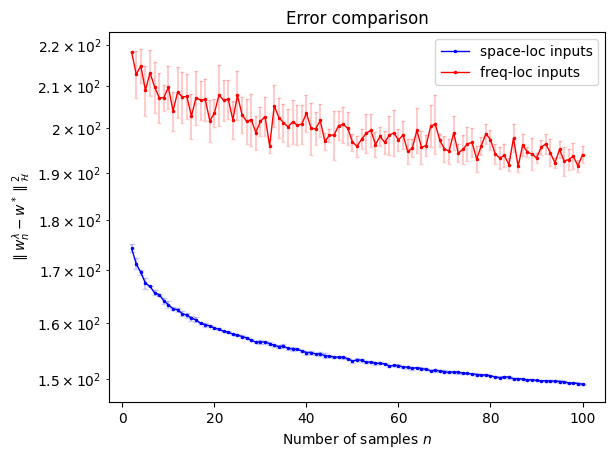

In [17]:
#plot the errors
# #error time-loc inputs

fig, ax = plt.subplots(1,  )

index = np.arange(1,error_squared_sampmean_time_loc.size+1)


#time-loc
ax.errorbar(index[1:], error_squared_sampmean_time_loc[1:], yerr =error_squared_sampstd_time_loc[1:], color='b', fmt='.', alpha=.2,capsize=2.5,ms=1)
ax.plot(index[1:], error_squared_sampmean_time_loc[1:], 'o-', markersize=1.5, color='b', alpha =1, lw=1, label=r'space-loc inputs')


#frequency-loc
ax.errorbar(index[1:], error_squared_sampmean_freq_loc[1:], yerr =error_squared_sampstd_freq_loc[1:], color='r', fmt='.', alpha=.2, capsize=1.5,ms=1)
ax.plot(index[1:], error_squared_sampmean_freq_loc[1:], 'o-', markersize=1.5, color='r', alpha =1.,lw =1,label=r'freq-loc inputs')

#################################
ax.set_xlabel(r'Number of samples $n$')
ax.set_ylabel(r'$ \parallel {w}^\lambda_n - w^* \parallel_{\mathcal{H}} ^2$')
# ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title(r'Error comparison')

ax.legend()
# plt.savefig('Error-comparison_no-rate.pdf', bbox_inches='tight')


## Idea: what about trying the Discrepancy Principle (since I know the noise)??

The discrepancy principle is a method for choosing the regularization parameter in inverse problems and other ill-posed problems. Its core idea is to balance the fidelity to the observed data with the regularization term by ensuring that the residual (i.e., the difference between the observed and predicted data) is consistent with the expected noise level.


If the noise in the data is Gaussian with a known standard deviation $\varepsilon$, and there are $m$ measurements, the expected level of noise in the data is approximately

$$
\delta = \tau \varepsilon \sqrt{m},
$$

where $\tau$ is a safety factor (often close to 1).

The discrepancy principle prescribes choosing $\lambda$ such that the norm of the residual

$$
r(\lambda) = \| X \star w_\lambda - Y \|
$$

satisfies

$$
r(\lambda) \approx \delta.
$$

### Practical Implementation

1. **Compute the Residual:** For a given $\lambda$, compute the regularized solution $w_\lambda$ and evaluate the residual $r(\lambda)$ (in time space? Fouirer?).
2. **Set the Target:** Determine the target residual level $\delta = \tau \sigma \sqrt{m}$.
3. **Adjust $\lambda$:** Use a root-finding method (e.g., Brent's method) to solve

   $$
   r(\lambda) - \delta = 0,
   $$

   thereby finding the $\lambda$ for which the discrepancy between the model prediction and the observed data is consistent with the noise level.

This approach avoids overfitting the noise by ensuring that the model does not try to explain variations that are within the expected noise range.
